# **Neural Network From Scratch (NumPy)**
This notebook implements a shallow neural network from scratch using NumPy
to study optimization behavior, activation functions, and gradient flow.

The focus is on understanding *how* backpropagation behaves rather than
building a production-ready model.


In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

## **Dataset**

We use the `make_moons` dataset because:

- It is **non-linearly separable**
- It has **only 2 features**, ideal for visualization
- It clearly demonstrates the need for hidden layers


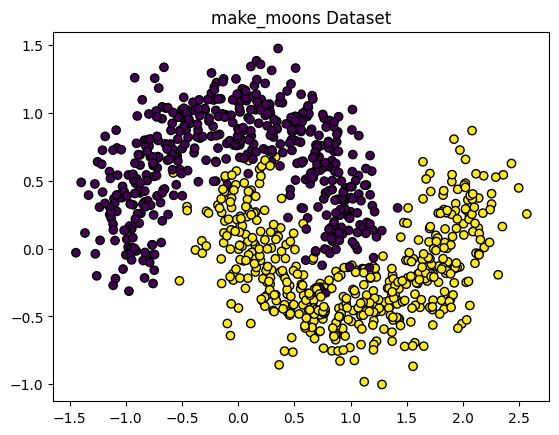

In [18]:
X, y = make_moons(n_samples=1000, noise=0.2, random_state=42)
y = y.reshape(-1, 1)

plt.scatter(X[:, 0], X[:, 1], c=y.flatten(), edgecolors="k")
plt.title("make_moons Dataset")
plt.show()

## **Feature Normalization**

Normalization is critical to prevent large activations,
which can push sigmoid into saturation and cause vanishing gradients.


In [ ]:
# Feature normalization to stabilize gradient descent
X_mean = X.mean(axis=0)
X_std = X.std(axis=0) + 1e-8
X = (X - X_mean) / X_std

## **Experiment Design**

The same neural network architecture is trained under different conditions
to isolate the effect of design choices:

- Activation function (Sigmoid vs ReLU)
- Number of hidden neurons

All other parameters are kept constant to ensure fair comparison.

In [ ]:
# Sigmoid squashes values into (0, 1), which can cause saturation
def sigmoid(z):
    return 1 / (1 + np.exp(-z))


def sigmoid_derivative(z):
    s = sigmoid(z)
    return s * (1 - s)


def relu(z):
    return np.maximum(0, z)


def relu_derivative(z):
    return (z > 0).astype(float)

In [ ]:
# Binary cross-entropy pairs naturally with sigmoid output
def binary_cross_entropy(y_true, y_pred):
    eps = 1e-8
    y_pred = np.clip(y_pred, eps, 1 - eps)

    loss = -(
        y_true * np.log(y_pred) +
        (1 - y_true) * np.log(1 - y_pred)
    )
    return np.mean(loss)

## **Model Parameters**

Architecture:
- Input layer: 2 features
- Hidden layer: configurable neurons
- Output layer: 1 neuron (sigmoid)

Weights are initialized with small random values
to avoid symmetry and exploding activations.


In [22]:
def initialize_parameters(input_dim, hidden_dim):
    W1 = 0.01 * np.random.randn(input_dim, hidden_dim)
    b1 = np.zeros((1, hidden_dim))

    W2 = 0.01 * np.random.randn(hidden_dim, 1)
    b2 = np.zeros((1, 1))

    return W1, b1, W2, b2

In [23]:
def forward_pass(X, W1, b1, W2, b2, activation="relu"):
    Z1 = X @ W1 + b1

    if activation == "relu":
        A1 = relu(Z1)
    else:
        A1 = sigmoid(Z1)

    Z2 = A1 @ W2 + b2
    y_pred = sigmoid(Z2)

    cache = (Z1, A1, Z2, y_pred)
    return y_pred, cache

In [24]:
def backward_pass(X, y, cache, W2, activation="relu"):
    Z1, A1, Z2, y_pred = cache
    m = X.shape[0]

    # Output layer gradient
    dZ2 = y_pred - y
    dW2 = (A1.T @ dZ2) / m
    db2 = np.sum(dZ2, axis=0, keepdims=True) / m

    # Hidden layer gradient
    dA1 = dZ2 @ W2.T

    if activation == "relu":
        dZ1 = dA1 * relu_derivative(Z1)
    else:
        dZ1 = dA1 * sigmoid_derivative(Z1)

    dW1 = (X.T @ dZ1) / m
    db1 = np.sum(dZ1, axis=0, keepdims=True) / m

    return dW1, db1, dW2, db2

In [ ]:
# Training using full-batch gradient descent
def train(X, y, hidden_dim, activation="relu", lr=0.05, epochs=1000):
    W1, b1, W2, b2 = initialize_parameters(2, hidden_dim)
    loss_history = []

    for epoch in range(epochs):
        y_pred, cache = forward_pass(X, W1, b1, W2, b2, activation)
        loss = binary_cross_entropy(y, y_pred)
        loss_history.append(loss)

        dW1, db1, dW2, db2 = backward_pass(X, y, cache, W2, activation)

        W1 -= lr * dW1
        b1 -= lr * db1
        W2 -= lr * dW2
        b2 -= lr * db2

    return W1, b1, W2, b2, loss_history

In [26]:
W1_s, b1_s, W2_s, b2_s, loss_sigmoid = train(
    X, y, hidden_dim=16, activation="sigmoid"
)

W1_r, b1_r, W2_r, b2_r, loss_relu = train(
    X, y, hidden_dim=16, activation="relu"
)

## **Activation Function Comparison**

The network is trained using Sigmoid and ReLU activations to observe
differences in convergence speed and gradient behavior.

**Note:**  
The model is evaluated on the training data to focus on
optimization dynamics and decision boundary behavior,
not generalization performance.

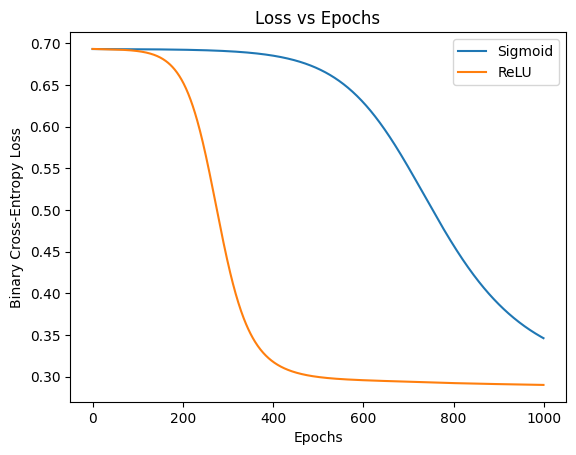

In [30]:
plt.plot(loss_sigmoid, label="Sigmoid")
plt.plot(loss_relu, label="ReLU")
plt.xlabel("Epochs")
plt.ylabel("Binary Cross-Entropy Loss")
plt.legend()
plt.title("Loss vs Epochs")
plt.show()

In [28]:
def plot_decision_boundary(W1, b1, W2, b2, activation, title):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 300),
        np.linspace(y_min, y_max, 300)
    )

    grid = np.c_[xx.ravel(), yy.ravel()]
    preds, _ = forward_pass(grid, W1, b1, W2, b2, activation)
    preds = (preds >= 0.5).astype(int).reshape(xx.shape)

    plt.contourf(xx, yy, preds, alpha=0.3)
    plt.scatter(X[:, 0], X[:, 1], c=y.flatten(), edgecolors="k")
    plt.title(title)
    plt.show()

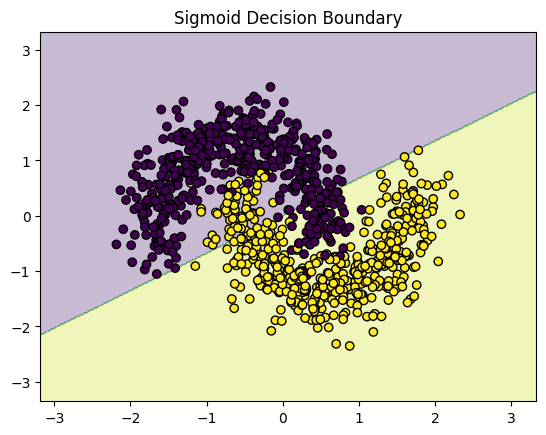

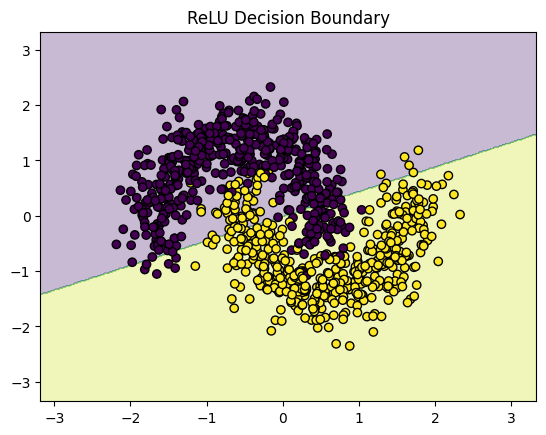

In [29]:
plot_decision_boundary(W1_s, b1_s, W2_s, b2_s, "sigmoid", "Sigmoid Decision Boundary")
plot_decision_boundary(W1_r, b1_r, W2_r, b2_r, "relu", "ReLU Decision Boundary")

## **Effect of Hidden Neurons**

The number of hidden neurons controls the expressive power of the network.
This experiment studies how increasing capacity affects the learned
decision boundary.

In [15]:
_, _, _, _, loss_relu_small = train(X, y, hidden_dim=4, activation="relu")
_, _, _, _, loss_relu_large = train(X, y, hidden_dim=32, activation="relu")

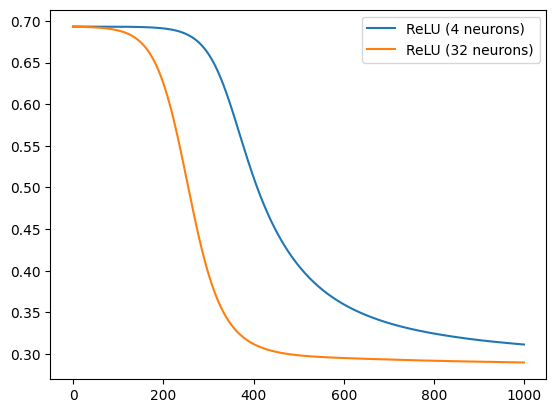

In [16]:
plt.plot(loss_relu_small, label="ReLU (4 neurons)")
plt.plot(loss_relu_large, label="ReLU (32 neurons)")
plt.legend()
plt.show()

### **Observations from Hidden Neuron Experiment**

Increasing the number of hidden neurons allows the network to learn
more complex decision boundaries, leading to faster convergence and
lower final loss. However, higher capacity also increases the risk of
overfitting in real-world settings.

## **Conclusion**

- Sigmoid activation converges more slowly due to saturation, exhibiting
  early signs of vanishing gradients.
- ReLU enables faster and more stable optimization by preserving gradient flow.
- Increasing the number of hidden neurons improves decision boundary flexibility,
  but also increases model complexity.
- This experiment demonstrates how architectural choices directly influence
  optimization dynamics in neural networks.